In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#importing cvxopt, the package for convex optimization 
import cvxopt as opt
from cvxopt import blas, solvers

np.random.seed(123)

#not showing progress
solvers.options['show_progress'] = False


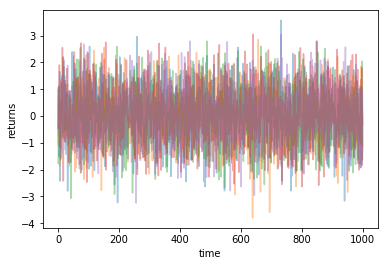

In [2]:
## NUMBER OF ASSETS##
n_assets = 5

## NUMBER OF OBSERVATIONS
n_obs = 1000 

#generate random series of Gaussian returns
return_vec = np.random.randn(n_assets, n_obs)

plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns');

In [3]:
def rand_weights(n):
    #Produces n random weights that sum to 1 
    k = np.random.rand(n)
    return k / sum(k)

print(rand_weights(n_assets))

[0.26616189 0.19260816 0.2285151  0.07462904 0.23808582]


In [4]:
def random_portfolio(returns): 
    #Returns the mean and standard deviation of returns for a random portfolio
  
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
        
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

In [5]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

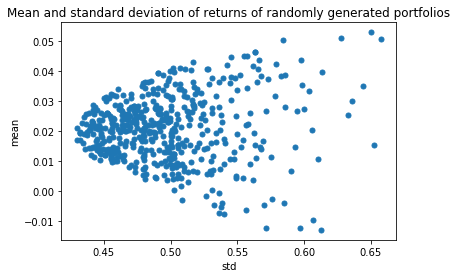

In [6]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios');

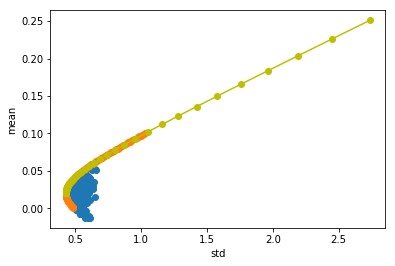

In [7]:
def  optimal_portfolio(returns,a,b):
    
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(b * t/N - a) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(1000.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]

    return returns, risks


a =1.5
b =5

#compute efficient frontier 
returns, risks = optimal_portfolio(return_vec,a,b)

#fit the quadratic mean-variance relation 
m1 = np.polyfit(returns, np.power(risks,2), 2)
x = np.linspace(0, 0.1, 100)
y = np.sqrt(m1[0]*x*x + m1[1]*x + m1[2])


plt.plot(stds, means, 'o')
plt.plot(y, x, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o');
plt.show()


In [8]:
from scipy.optimize import fsolve
import math

#riskfree rate
riskfree = 2.7/(100*365)
#riskfree = 0

#efficient frontier, expressed as sigma vs mu 
def sigma(mu):
    return np.sqrt(m1[0]*mu*mu + m1[1]*mu + m1[2])

#slope of the efficient frontier, expressed as sigma vs mu 
def slope(mu):
    return (m1[0]*mu + m1[1]/2)/sigma(mu)

#nonlinear equation to find the tangency portfolio 
def equations(p):
    mu = p
    return (sigma(mu) - slope(mu)*(mu - riskfree))

#finding the tangency portfolio 
mu2 =  fsolve(equations, (15))
sigma2 = sigma(mu2)

#finding the slope of the tangency portfolio (Sharpe Ratio)
m = slope(mu2)

[sigma2, mu2]

[array([0.90320428]), array([0.08781844])]

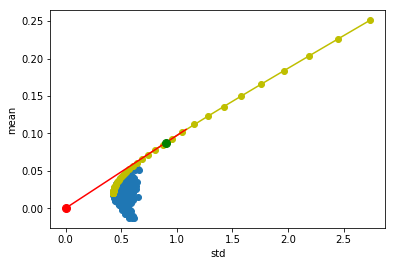

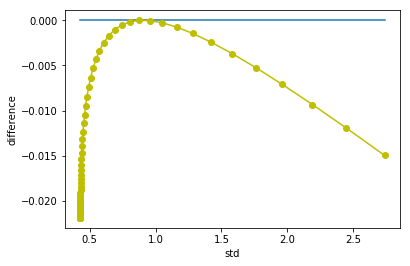

In [9]:
x = np.linspace(0, 1.2*sigma2, 1000)

#plotting random portfolios (blue)
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')


#plotting the efficient frontier (yellow)
plt.plot(risks, returns, 'y-o');

#plotting the tangent line to the efficient frontier (red)
plt.plot(x, x/m + riskfree, 'r-')

#showing the risk-free investment
plt.plot(0,riskfree, 'r-o',markersize=8);

#showing the point of tangency 
plt.plot(sigma2,mu2, 'g-o',markersize=8);
plt.show()

#checking the tangency condition 
plt.ylabel('difference')
plt.xlabel('std')
plt.plot(risks,np.zeros([len(risks), 1]))
plt.plot(risks, returns - risks/m - riskfree, 'y-o');
plt.show()


[0.903207824947689, 0.08781878187818783]

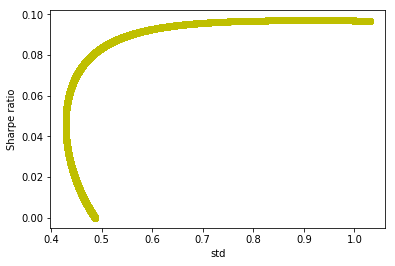

In [10]:
#checking that the tangency portfolio yields the optimal Sharpe ratio 
x = np.linspace(0, 0.1, 10000)
y = np.sqrt(m1[0]*x*x + m1[1]*x + m1[2])

SR = (x - riskfree)/y

plt.ylabel('Sharpe ratio')
plt.xlabel('std')
plt.plot(y,SR, 'y-o')

[y[SR.argmax()], x[SR.argmax()]]

In [15]:
#importing real data with pandas 

import pandas
from pandas_datareader import data as pdr

gold = pandas.read_csv('Gold.csv')
gspc = pandas.read_csv('GSPC.csv')
btc = pandas.read_csv('BTC.csv')


In [16]:
btc.tail()

,Date,Price
360,31/08/2018 00:00,6981.946154
361,01/09/2018 00:00,7100.946667
362,02/09/2018 00:00,7247.935385
363,03/09/2018 00:00,7260.949231
364,04/09/2018 00:00,7326.852500


In [17]:
def split_dataset(data, testrange, trainrange):
    train = data[-testrange-trainrange:-testrange]
    test = data[-testrange:]
    return train, test

#computing returns from prices
def price2rets(prices):
    return prices[:-1] / prices[1:] - 1

#decide the size of the training set and test set
timerange_test = 50
timerange_train = 100

#extract the last timerange_test + timerange_train data points 
btc_series = np.array(btc['Price'][-timerange_test - timerange_train - 1:-1])
gspc_series = np.array(gspc['Close'][-timerange_test - timerange_train - 1:-1])
gold_series = np.array(gold['Price'][-timerange_test - timerange_train:])

btc_series_train, btc_series_test = split_dataset(btc_series, timerange_test, timerange_train)
gspc_series_train, gspc_series_test = split_dataset(gspc_series, timerange_test, timerange_train)
gold_series_train, gold_series_test = split_dataset(gold_series, timerange_test, timerange_train)

    
return_vec_train = np.zeros([3, timerange_train-1])

return_vec_train[0][:] = price2rets(btc_series_train)
return_vec_train[1][:] = price2rets(gspc_series_train)
return_vec_train[2][:] = price2rets(gold_series_train)


return_vec_test = np.zeros([3, timerange_test-1])

return_vec_test[0][:] = price2rets(btc_series_test)
return_vec_test[1][:] = price2rets(gspc_series_test)
return_vec_test[2][:] = price2rets(gold_series_test)

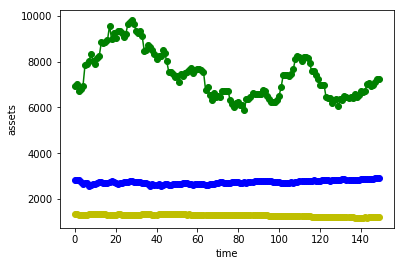

In [18]:
#displaying the time series 
plt.ylabel('assets')
plt.xlabel('time')
plt.plot(btc_series, 'g-o')
plt.plot(gspc_series, 'b-o')
plt.plot(gold_series, 'y-o')

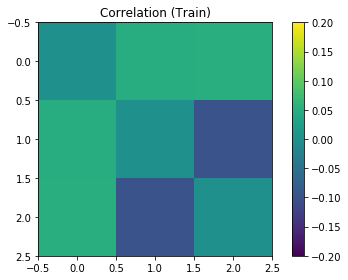

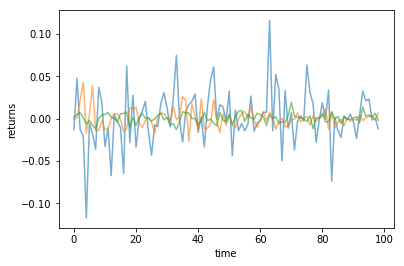

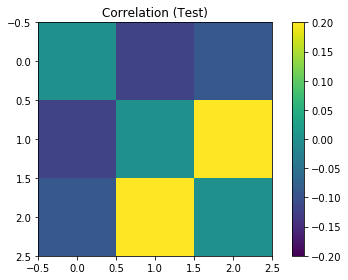

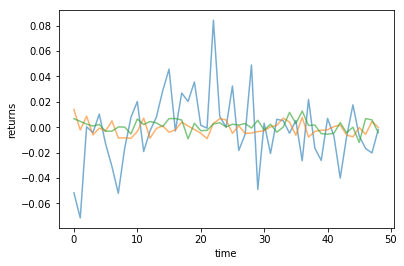

In [19]:
#computing and plotting correlation matrices
C = np.corrcoef(return_vec_train) 
C = C - np.diag(np.diag(C))

fig, ax = plt.subplots()
im = ax.imshow(C,clim=(-0.2, 0.2))
cbar = fig.colorbar(im)

ax.set_title("Correlation (Train)")
fig.tight_layout()
plt.show()

#plotting the training data
plt.plot(return_vec_train.T, alpha=.6);
plt.xlabel('time')
plt.ylabel('returns');

C = np.corrcoef(return_vec_test) 
C = C - np.diag(np.diag(C))

fig, ax = plt.subplots()
im = ax.imshow(C,clim=(-0.2, 0.2))
cbar = fig.colorbar(im)

ax.set_title("Correlation (Test)")
fig.tight_layout()
plt.show()


#plotting the test data
plt.plot(return_vec_test.T, alpha=.6);
plt.xlabel('time')
plt.ylabel('returns');

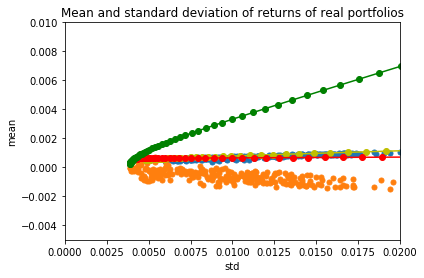

In [20]:
def  evaluate_optimal_portfolio(returns_train,returns_test,a,b):
    n = len(returns_train)
    returns_train = np.asmatrix(returns_train)
    returns_test = np.asmatrix(returns_test)

    
    N = 100
    mus = [10**(b * t/N - a) for t in range(N)]
    
    # training set
    S_train = opt.matrix(np.cov(returns_train))
    pbar_train = opt.matrix(np.mean(returns_train, axis=1))
    
    # test set 
    S_test = opt.matrix(np.cov(returns_test))
    pbar_test = opt.matrix(np.mean(returns_test, axis=1))

    # Create constraint matrices
    G = opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(1000.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming based on the training data
    portfolios = [solvers.qp(mu*S_train, -pbar_train, G, h, A, b)['x'] 
                  for mu in mus]
    
    
    ## CALCULATE RISKS AND RETURNS performance of the optimal portfolios in the test dataset 
    returns = [blas.dot(pbar_test, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S_test*x)) for x in portfolios]

    return returns, risks


a = 0.1
b = 3

returns_train, risks_train = optimal_portfolio(return_vec_train,a,b)
returns_test, risks_test = evaluate_optimal_portfolio(return_vec_train,return_vec_test,a,b)
returns_opt, risks_opt = optimal_portfolio(return_vec_test,a,b)


#sample random portfolios in the training set
n_portfolios = 250
means_train, stds_train = np.column_stack([
    random_portfolio(return_vec_train) 
    for _ in range(n_portfolios)
])

#sample random portfolios in the test set
n_portfolios = 250
means, stds = np.column_stack([
    random_portfolio(return_vec_test) 
    for _ in range(n_portfolios)
])


plt.ylabel('mean')
plt.xlabel('std')

#plotting random portfolios in the training set (blue)
plt.plot(stds_train, means_train, 'o', markersize=5)

#plotting random portfolios in the test set (orange)
plt.plot(stds, means, 'o', markersize=5)

#plotting the efficient frontier for the training set (yellow)
plt.plot(risks_train, returns_train, 'y-o');

#plotting the performance of efficient frontier portfolios on the test set (red)
plt.plot(risks_test, returns_test, 'r-o');

#plotting the efficient frontier for the test set (green)
plt.plot(risks_opt, returns_opt, 'g-o');

plt.ylim(-0.005, 0.01)  
plt.xlim(0,0.02)

plt.title('Mean and standard deviation of returns of real portfolios');